
**Import necessary libraries**

In [1]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import zipfile
import os

# File handling in Colab
from google.colab import files

In [2]:
# Upload the file
uploaded = files.upload()

# Unzip the file
zip_file_path = list(uploaded.keys())[0]
unzip_dir = '/content/student_performance_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# List the contents to confirm extraction
extracted_files = os.listdir(unzip_dir)
print(extracted_files)

Saving student+performance.zip to student+performance.zip
['.student.zip_old', 'student.zip']


In [3]:
# List the contents of the extraction directory
extracted_files = os.listdir(unzip_dir)
print(extracted_files)

['.student.zip_old', 'student.zip']


In [4]:
# Path to the nested zip file
nested_zip_file_path = os.path.join(unzip_dir, 'student.zip')

In [5]:
# Create a new directory to extract the contents of student.zip
nested_unzip_dir = os.path.join(unzip_dir, 'student_performance_dataset')
os.makedirs(nested_unzip_dir, exist_ok=True)

In [6]:
# Unzipping the nested zip file
with zipfile.ZipFile(nested_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(nested_unzip_dir)

In [7]:
# List the contents of the newly extracted directory
extracted_files_nested = os.listdir(nested_unzip_dir)
print(extracted_files_nested)

['student-merge.R', 'student-por.csv', 'student.txt', 'student-mat.csv']


In [8]:
# Update the file paths to point to the extracted files
mat_file_path = os.path.join(nested_unzip_dir, 'student-mat.csv')
por_file_path = os.path.join(nested_unzip_dir, 'student-por.csv')

In [9]:
# Load the CSV files into pandas DataFrames
student_mat_df = pd.read_csv(mat_file_path, delimiter=';')
student_por_df = pd.read_csv(por_file_path, delimiter=';')

In [10]:
# Display the first few rows to inspect the data
print(student_mat_df.head())
print(student_por_df.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     G

In [11]:
student_por_df.info()
student_mat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [12]:
# Check for missing values and handle them
numeric_cols = student_mat_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = student_mat_df.select_dtypes(include=['object']).columns

In [13]:
# Impute missing values for numeric columns using the median strategy
imputer_numeric = SimpleImputer(strategy='median')
student_mat_df[numeric_cols] = imputer_numeric.fit_transform(student_mat_df[numeric_cols])
student_por_df[numeric_cols] = imputer_numeric.fit_transform(student_por_df[numeric_cols])

In [14]:
# Impute missing values for categorical columns using the most frequent strategy
imputer_categorical = SimpleImputer(strategy='most_frequent')
student_mat_df[categorical_cols] = imputer_categorical.fit_transform(student_mat_df[categorical_cols])
student_por_df[categorical_cols] = imputer_categorical.fit_transform(student_por_df[categorical_cols])

# Data Preprocessing and Analysis

**Feature Engineering**

In [15]:
# Create new features
student_mat_df['attendance_rate'] = 1 - (student_mat_df['absences'] / 100)
student_por_df['attendance_rate'] = 1 - (student_por_df['absences'] / 100)

student_mat_df['avg_homework_score'] = student_mat_df['studytime'] / student_mat_df['studytime'].max()
student_por_df['avg_homework_score'] = student_por_df['studytime'] / student_por_df['studytime'].max()

student_mat_df['parental_involvement'] = (student_mat_df['Medu'] + student_mat_df['Fedu']) / 2
student_por_df['parental_involvement'] = (student_por_df['Medu'] + student_por_df['Fedu']) / 2

**Target Variable Handling**

In [16]:
# 'G3' is the target variable
y_mat = student_mat_df['G3']
y_por = student_por_df['G3']

Class Balancing

In [17]:
# Convert G3 into broader categories (low, medium, high performance)
def categorize_grades(g):
    if g < 10:
        return 0  # Low performance
    elif 10 <= g <= 14:
        return 1  # Medium performance
    else:
        return 2  # High performance

y_mat_class = y_mat.apply(categorize_grades)
y_por_class = y_por.apply(categorize_grades)

In [18]:
# Drop the target variable from the feature set (X) since it should not be part of the input features
X_mat = student_mat_df.drop(columns=['G3'])
X_por = student_por_df.drop(columns=['G3'])

 One-Hot Encoding

In [19]:
# Apply One-Hot Encoding to categorical variables
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
X_mat = pd.get_dummies(X_mat, columns=categorical_features, drop_first=True)
X_por = pd.get_dummies(X_por, columns=categorical_features, drop_first=True)

In [20]:
# Align the columns between the two datasets (in case of mismatch after encoding)
X_mat, X_por = X_mat.align(X_por, join='outer', axis=1, fill_value=0)

Scaling

In [21]:
# Scaling numerical features using PowerTransformer
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
power_transformer = PowerTransformer()
X_mat[numerical_features] = power_transformer.fit_transform(X_mat[numerical_features])
X_por[numerical_features] = power_transformer.fit_transform(X_por[numerical_features])

# Train/Test Split


In [22]:
# Train/Test split
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(X_mat, y_mat_class, test_size=0.3, random_state=42)
X_train_por, X_test_por, y_train_por, y_test_por = train_test_split(X_por, y_por_class, test_size=0.3, random_state=42)

In [23]:
# Print the shapes of the resulting splits
print("Mathematics Data Split:")
print("X_train_mat shape:", X_train_mat.shape)
print("X_test_mat shape:", X_test_mat.shape)
print("y_train_mat shape:", y_train_mat.shape)
print("y_test_mat shape:", y_test_mat.shape)

print("\nPortuguese Data Split:")
print("X_train_por shape:", X_train_por.shape)
print("X_test_por shape:", X_test_por.shape)
print("y_train_por shape:", y_train_por.shape)
print("y_test_por shape:", y_test_por.shape)

Mathematics Data Split:
X_train_mat shape: (276, 44)
X_test_mat shape: (119, 44)
y_train_mat shape: (276,)
y_test_mat shape: (119,)

Portuguese Data Split:
X_train_por shape: (454, 44)
X_test_por shape: (195, 44)
y_train_por shape: (454,)
y_test_por shape: (195,)


In [24]:
# Apply Oversampling (SMOTE) to Balance Classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_mat, y_train_mat = smote.fit_resample(X_train_mat, y_train_mat)

# Modeling

---------------------------------------------------         **Random Forest Model with Grid Search**      ----------------------------------------------------

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for Random Forest classification
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Instantiate RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# -------------------- Mathematics Dataset --------------------
# Use GridSearchCV for hyperparameter tuning on Mathematics dataset
rf_grid_search_mat = GridSearchCV(rf_classifier, rf_param_grid, cv=10, n_jobs=-1, scoring='f1_macro')
rf_grid_search_mat.fit(X_train_mat, y_train_mat)

# Best Random Forest Classifier Model for Mathematics
rf_best_mat = rf_grid_search_mat.best_estimator_

# Predict on the test set for Mathematics dataset
rf_pred_class_mat = rf_best_mat.predict(X_test_mat)

# Evaluate Random Forest classifier using precision, recall, and F1-score
print("Random Forest Classification Report (Mathematics):")
print(classification_report(y_test_mat, rf_pred_class_mat, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=1))

# -------------------- Portuguese Dataset --------------------
# Use GridSearchCV for hyperparameter tuning on Portuguese dataset
rf_grid_search_por = GridSearchCV(rf_classifier, rf_param_grid, cv=10, n_jobs=-1, scoring='f1_macro')
rf_grid_search_por.fit(X_train_por, y_train_por)

# Best Random Forest Classifier Model for Portuguese
rf_best_por = rf_grid_search_por.best_estimator_

# Predict on the test set for Portuguese dataset
rf_pred_class_por = rf_best_por.predict(X_test_por)

# Evaluate Random Forest classifier using precision, recall, and F1-score
print("Random Forest Classification Report (Portuguese):")
print(classification_report(y_test_por, rf_pred_class_por, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=1))


Random Forest Classification Report (Mathematics):
              precision    recall  f1-score   support

     Class 0       0.85      0.89      0.87        46
     Class 1       0.85      0.85      0.85        48
     Class 2       1.00      0.92      0.96        25

    accuracy                           0.88       119
   macro avg       0.90      0.89      0.89       119
weighted avg       0.88      0.88      0.88       119

Random Forest Classification Report (Portuguese):
              precision    recall  f1-score   support

     Class 0       0.89      0.65      0.76        26
     Class 1       0.92      0.96      0.94       125
     Class 2       0.93      0.98      0.96        44

    accuracy                           0.92       195
   macro avg       0.92      0.86      0.88       195
weighted avg       0.92      0.92      0.92       195



----------------------------------------------------------- **XGBoost Model with Grid Search** ---------------------------------------------------------

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for XGBoost classification
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Instantiate XGBClassifier
xgb_classifier = XGBClassifier(random_state=42)

# -------------------- Mathematics Dataset --------------------
# Use GridSearchCV for hyperparameter tuning on Mathematics dataset
xgb_grid_search_mat = GridSearchCV(xgb_classifier, xgb_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
xgb_grid_search_mat.fit(X_train_mat, y_train_mat)

# Best XGBoost Classifier Model for Mathematics
xgb_best_mat = xgb_grid_search_mat.best_estimator_

# Predict on the test set for Mathematics dataset
xgb_pred_class_mat = xgb_best_mat.predict(X_test_mat)

# Evaluate XGBoost classifier using precision, recall, and F1-score for Mathematics
print("XGBoost Classification Report (Mathematics):")
print(classification_report(y_test_mat, xgb_pred_class_mat, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=1))

# -------------------- Portuguese Dataset --------------------
# Use GridSearchCV for hyperparameter tuning on Portuguese dataset
xgb_grid_search_por = GridSearchCV(xgb_classifier, xgb_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
xgb_grid_search_por.fit(X_train_por, y_train_por)

# Best XGBoost Classifier Model for Portuguese
xgb_best_por = xgb_grid_search_por.best_estimator_

# Predict on the test set for Portuguese dataset
xgb_pred_class_por = xgb_best_por.predict(X_test_por)

# Evaluate XGBoost classifier using precision, recall, and F1-score for Portuguese
print("XGBoost Classification Report (Portuguese):")
print(classification_report(y_test_por, xgb_pred_class_por, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=1))


XGBoost Classification Report (Mathematics):
              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.89        46
     Class 1       0.86      0.88      0.87        48
     Class 2       1.00      0.88      0.94        25

    accuracy                           0.89       119
   macro avg       0.91      0.89      0.90       119
weighted avg       0.89      0.89      0.89       119

XGBoost Classification Report (Portuguese):
              precision    recall  f1-score   support

     Class 0       0.73      0.73      0.73        26
     Class 1       0.93      0.92      0.93       125
     Class 2       0.93      0.98      0.96        44

    accuracy                           0.91       195
   macro avg       0.87      0.88      0.87       195
weighted avg       0.91      0.91      0.91       195



# Cross-Validation for Both Models

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define the parameter grids for both Random Forest and XGBoost
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Instantiate the models
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)

# -------------------- Random Forest Cross-Validation --------------------

# Use GridSearchCV to tune hyperparameters for Random Forest on the Mathematics dataset
rf_grid_search_mat = GridSearchCV(rf_classifier, rf_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
rf_grid_search_mat.fit(X_train_mat, y_train_mat)

# Get the best Random Forest estimator
rf_best_mat = rf_grid_search_mat.best_estimator_

# Perform 5-fold cross-validation for Random Forest
rf_cv_scores_mat = cross_val_score(rf_best_mat, X_train_mat, y_train_mat, cv=5, scoring='f1_macro')

# Print cross-validation results
print("Random Forest Cross-Validation Scores (Mathematics):", rf_cv_scores_mat)
print("Random Forest Mean CV F1-Score (Mathematics):", rf_cv_scores_mat.mean())

# -------------------- XGBoost Cross-Validation --------------------

# Use GridSearchCV to tune hyperparameters for XGBoost on the Mathematics dataset
xgb_grid_search_mat = GridSearchCV(xgb_classifier, xgb_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
xgb_grid_search_mat.fit(X_train_mat, y_train_mat)

# Get the best XGBoost estimator
xgb_best_mat = xgb_grid_search_mat.best_estimator_

# Perform 5-fold cross-validation for XGBoost
xgb_cv_scores_mat = cross_val_score(xgb_best_mat, X_train_mat, y_train_mat, cv=5, scoring='f1_macro')

# Print cross-validation results
print("XGBoost Cross-Validation Scores (Mathematics):", xgb_cv_scores_mat)
print("XGBoost Mean CV F1-Score (Mathematics):", xgb_cv_scores_mat.mean())

# -------------------- Repeat for Portuguese Dataset --------------------

# Random Forest cross-validation for Portuguese dataset
rf_grid_search_por = GridSearchCV(rf_classifier, rf_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
rf_grid_search_por.fit(X_train_por, y_train_por)
rf_best_por = rf_grid_search_por.best_estimator_
rf_cv_scores_por = cross_val_score(rf_best_por, X_train_por, y_train_por, cv=5, scoring='f1_macro')
print("Random Forest Cross-Validation Scores (Portuguese):", rf_cv_scores_por)
print("Random Forest Mean CV F1-Score (Portuguese):", rf_cv_scores_por.mean())

# XGBoost cross-validation for Portuguese dataset
xgb_grid_search_por = GridSearchCV(xgb_classifier, xgb_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
xgb_grid_search_por.fit(X_train_por, y_train_por)
xgb_best_por = xgb_grid_search_por.best_estimator_
xgb_cv_scores_por = cross_val_score(xgb_best_por, X_train_por, y_train_por, cv=5, scoring='f1_macro')
print("XGBoost Cross-Validation Scores (Portuguese):", xgb_cv_scores_por)
print("XGBoost Mean CV F1-Score (Portuguese):", xgb_cv_scores_por.mean())

Random Forest Cross-Validation Scores (Mathematics): [0.92012127 0.86419753 0.8838141  0.95270977 0.95213675]
Random Forest Mean CV F1-Score (Mathematics): 0.9145958846095859
XGBoost Cross-Validation Scores (Mathematics): [0.96550699 0.85268199 0.94209843 0.95320197 0.96467421]
XGBoost Mean CV F1-Score (Mathematics): 0.9356327177539319
Random Forest Cross-Validation Scores (Portuguese): [0.91457587 0.83403183 0.8393266  0.73648485 0.79284816]
Random Forest Mean CV F1-Score (Portuguese): 0.8234534611890592
XGBoost Cross-Validation Scores (Portuguese): [0.88359813 0.87984042 0.9251462  0.82778297 0.832719  ]
XGBoost Mean CV F1-Score (Portuguese): 0.8698173436030027


**Feature Importance Visualization**

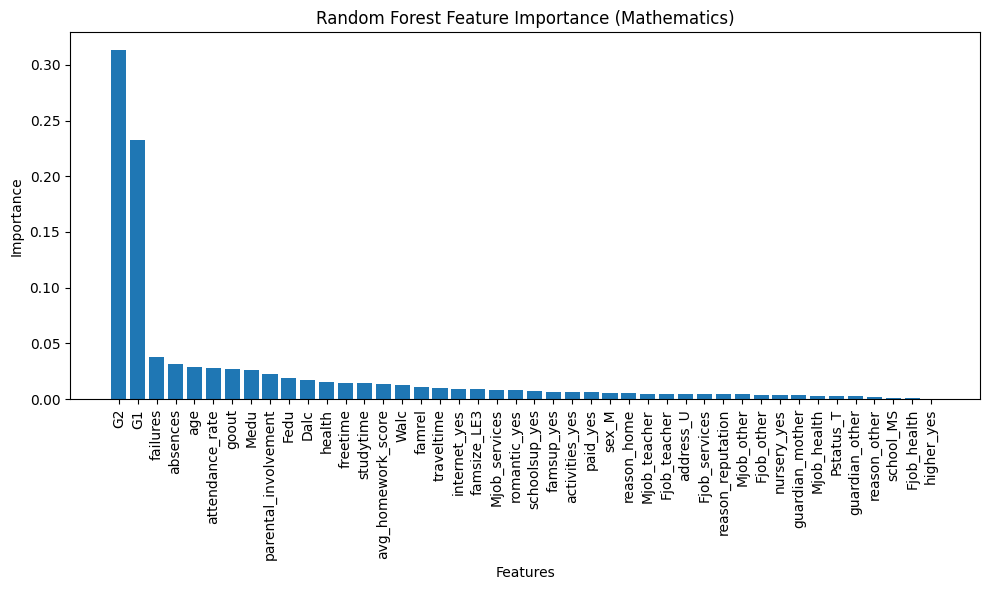

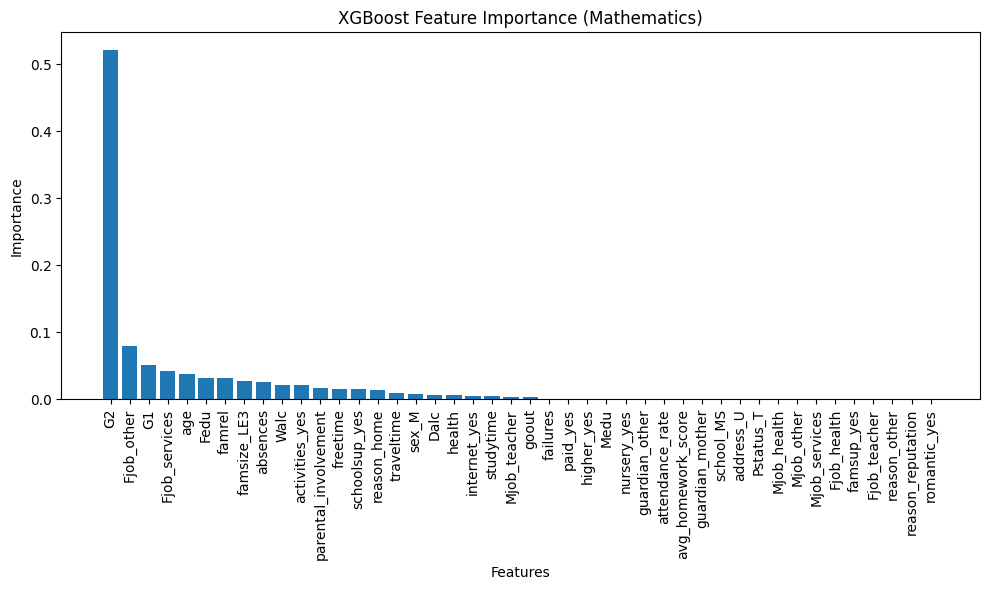

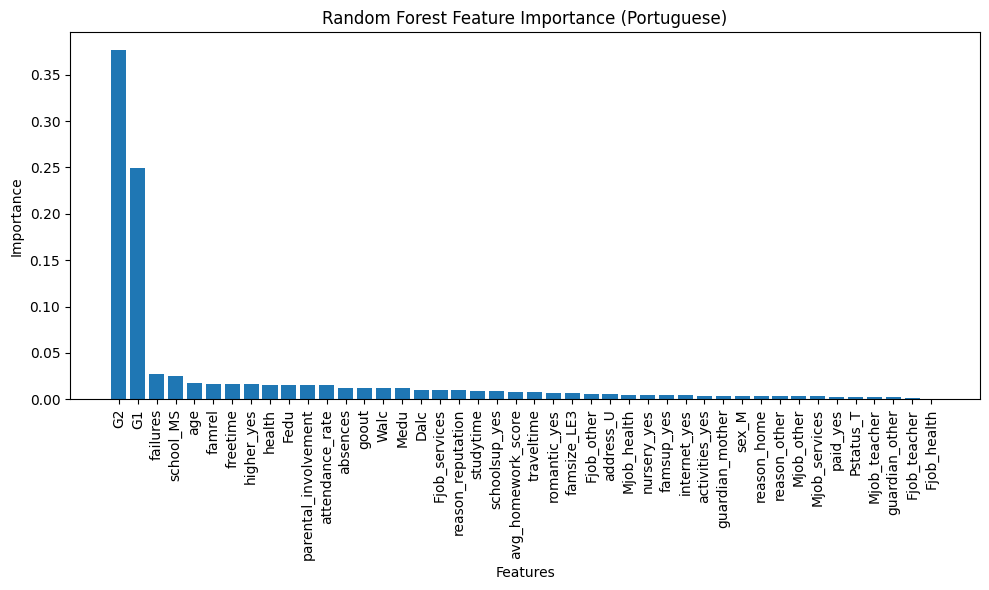

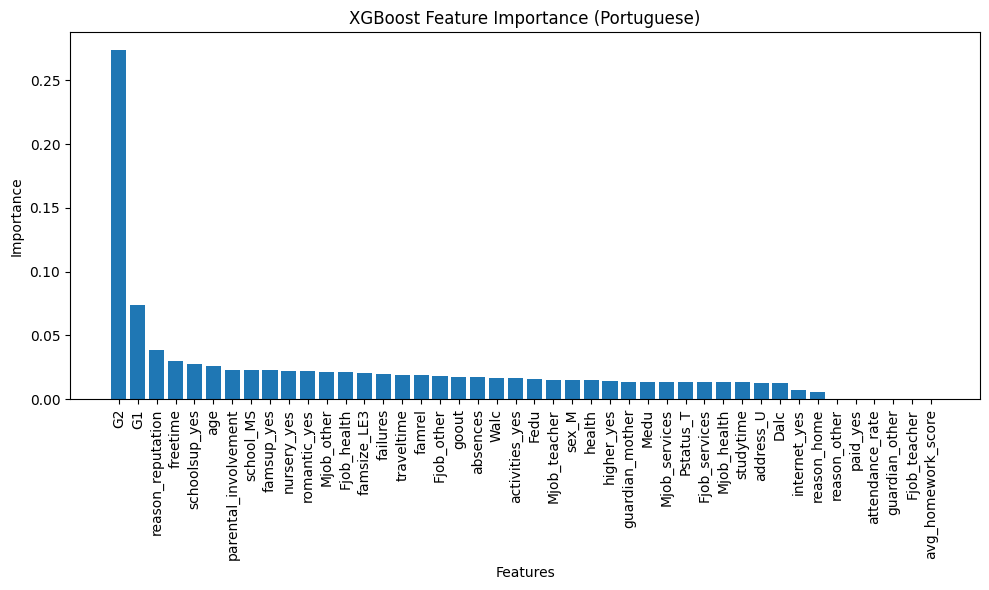

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------- Random Forest Feature Importance --------------------

# Extract feature importances from the best Random Forest model for Mathematics
rf_feature_importances_mat = rf_best_mat.feature_importances_

# Sort feature importances in descending order
indices_rf_mat = np.argsort(rf_feature_importances_mat)[::-1]

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance (Mathematics)")
plt.bar(range(X_train_mat.shape[1]), rf_feature_importances_mat[indices_rf_mat], align="center")
plt.xticks(range(X_train_mat.shape[1]), np.array(X_train_mat.columns)[indices_rf_mat], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# -------------------- XGBoost Feature Importance --------------------

# Extract feature importances from the best XGBoost model for Mathematics
xgb_feature_importances_mat = xgb_best_mat.feature_importances_

# Sort feature importances in descending order
indices_xgb_mat = np.argsort(xgb_feature_importances_mat)[::-1]

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importance (Mathematics)")
plt.bar(range(X_train_mat.shape[1]), xgb_feature_importances_mat[indices_xgb_mat], align="center")
plt.xticks(range(X_train_mat.shape[1]), np.array(X_train_mat.columns)[indices_xgb_mat], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# -------------------- Repeat for Portuguese Dataset --------------------

# Random Forest feature importance for Portuguese dataset
rf_feature_importances_por = rf_best_por.feature_importances_
indices_rf_por = np.argsort(rf_feature_importances_por)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance (Portuguese)")
plt.bar(range(X_train_por.shape[1]), rf_feature_importances_por[indices_rf_por], align="center")
plt.xticks(range(X_train_por.shape[1]), np.array(X_train_por.columns)[indices_rf_por], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# XGBoost feature importance for Portuguese dataset
xgb_feature_importances_por = xgb_best_por.feature_importances_
indices_xgb_por = np.argsort(xgb_feature_importances_por)[::-1]
plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importance (Portuguese)")
plt.bar(range(X_train_por.shape[1]), xgb_feature_importances_por[indices_xgb_por], align="center")
plt.xticks(range(X_train_por.shape[1]), np.array(X_train_por.columns)[indices_xgb_por], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Visualization and Results Analysis

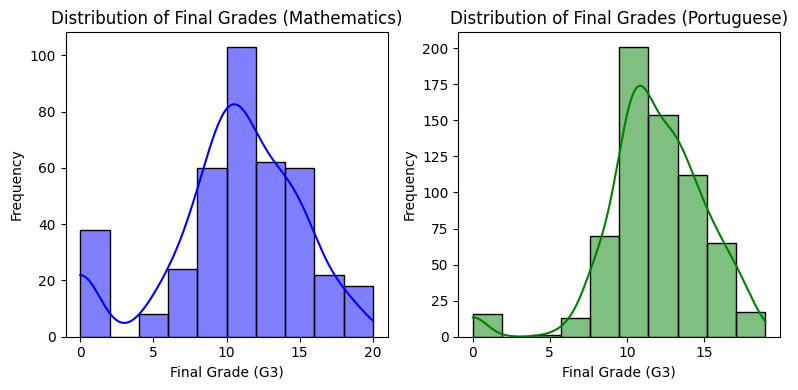

In [43]:
# Histograms for grade distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(student_mat_df['G3'], bins=10, kde=True, color='blue')
plt.title('Distribution of Final Grades (Mathematics)')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(student_por_df['G3'], bins=10, kde=True, color='green')
plt.title('Distribution of Final Grades (Portuguese)')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

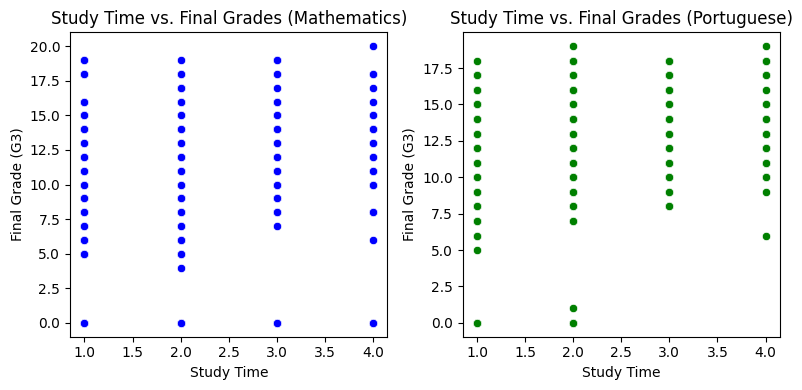

In [44]:
# Scatter plots for study time vs. grades
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x='studytime', y='G3', data=student_mat_df, color='blue')
plt.title('Study Time vs. Final Grades (Mathematics)')
plt.xlabel('Study Time')
plt.ylabel('Final Grade (G3)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='studytime', y='G3', data=student_por_df, color='green')
plt.title('Study Time vs. Final Grades (Portuguese)')
plt.xlabel('Study Time')
plt.ylabel('Final Grade (G3)')

plt.tight_layout()
plt.show()

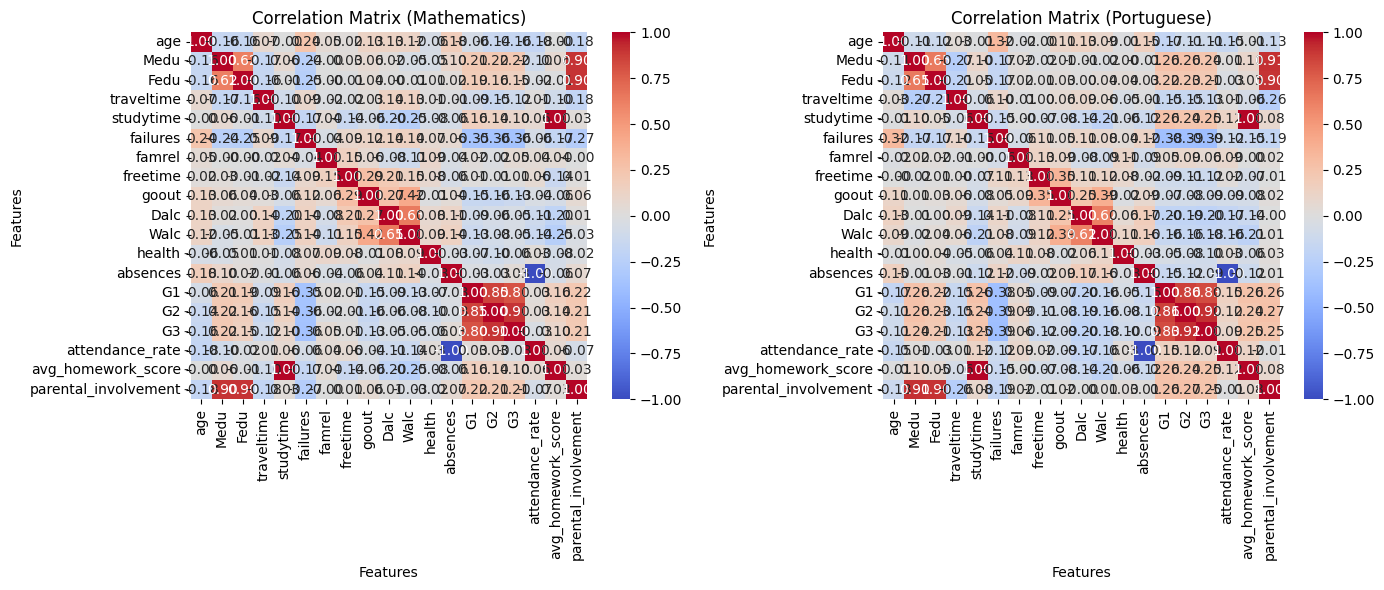

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns
student_mat_df_numeric = student_mat_df.select_dtypes(include=[np.number])
student_por_df_numeric = student_por_df.select_dtypes(include=[np.number])

# Heatmaps for correlations
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(student_mat_df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Mathematics)')
plt.xlabel('Features')
plt.ylabel('Features')

plt.subplot(1, 2, 2)
sns.heatmap(student_por_df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Portuguese)')
plt.xlabel('Features')
plt.ylabel('Features')

plt.tight_layout()
plt.show()